In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import levene
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind, mannwhitneyu
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [9]:
df_2023= pd.read_csv('data/2023/외래관광객조사_2023_전처리3(세분화).csv')
df_2024= pd.read_csv('data/2024/외래관광객조사_2024_전처리3(세분화).csv')

In [16]:
# 2024년 컬럼명 통일
df_2024.rename(columns={
    '총액1인TOT_개별국제교통비제외2': '총액1인TOT항공제외2'
}, inplace=True)

In [17]:
print('총액1인TOT_개별국제교통비제외2' in df_2024.columns)

False


In [18]:
print('총액1인TOT항공제외2' in df_2024.columns)

True


In [19]:
print(df_2024.columns.tolist())

['D_NAT', 'M일HAP', 'Q7A', 'Q7a_dk', 'Q7a2', 'Q7a3', 'Q7a4', 'Q7a5', 'Q7a6', 'Q7a7', 'Q7a8', 'D_GUB', 'D_MOK', '총액1인TOT항공제외2', 'Q8a03', 'Q8a12', 'Q8_1a1', 'Q8_1a2', 'Q8_1a3', 'D_AGE', '동행자_단순', '동행자_세분화', '국가명', '연령대_단순', '연령대_세분화', '웰니스참여', '웰니스만족', 'log_총액', 'year']


In [20]:
# 23, 24년도 데이터 병합
df_all = pd.concat([df_2023, df_2024], ignore_index=True)

In [21]:
# 병합된 데이터 확인
print(df_all.shape)
print(df_all['year'].value_counts())  # 연도별 분포 확인

(17123, 29)
year
2024    8769
2023    8354
Name: count, dtype: int64


### 연령대별 사용 총액 분석

In [22]:
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [26]:
# 연령대별 평균 총액
avg_total_by_age = df_all.groupby('연령대_단순')['총액1인TOT항공제외2'].mean().round(1).sort_index()
print(avg_total_by_age)

연령대_단순
10대       1160.0
20대       1268.6
30~50대    1445.3
60대 이상    1252.9
Name: 총액1인TOT항공제외2, dtype: float64


- 30~50대가 총액1인소비가 가장 큰 그룹으로 나타남
- 30~50대 > 20대 > 60대 이상 > 10대 순으로 연령대별 평균 소비 총액을 확인할 수 있음 

In [66]:
df_all['연령대_세분화'].value_counts()

연령대_세분화
20대       6117
30대       4189
50대       2776
40대       2631
60대 이상     974
10대        436
Name: count, dtype: int64

In [67]:
# 연령대별 평균 총액
avg_total_by_age = df_all.groupby('연령대_세분화')['총액1인TOT항공제외2'].mean().round(1).sort_index()
print(avg_total_by_age)

연령대_세분화
10대       1160.0
20대       1268.6
30대       1465.3
40대       1476.9
50대       1385.0
60대 이상    1252.9
Name: 총액1인TOT항공제외2, dtype: float64


In [28]:
print(df_all['총액1인TOT항공제외2'].describe())

count    17123.000000
mean      1363.952237
std       1272.311095
min        139.800000
25%        665.133847
50%        987.620000
75%       1561.700000
max       9549.510000
Name: 총액1인TOT항공제외2, dtype: float64


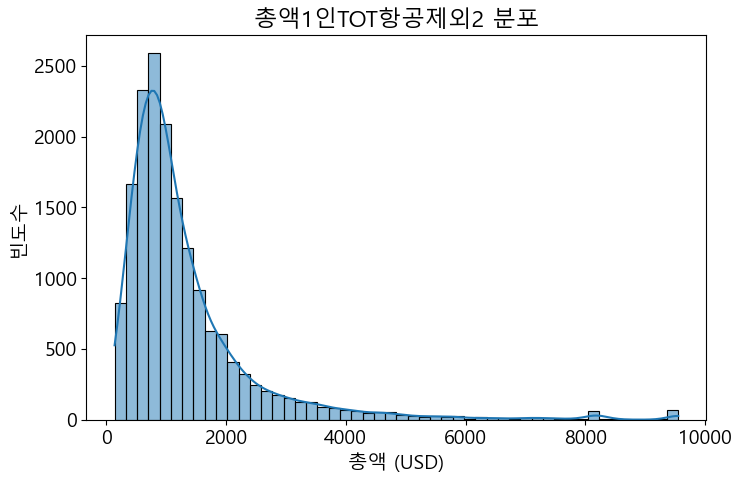

In [30]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['총액1인TOT항공제외2'], bins=50, kde=True)
plt.title("총액1인TOT항공제외2 분포")
plt.xlabel("총액 (USD)")
plt.ylabel("빈도수")
plt.show()

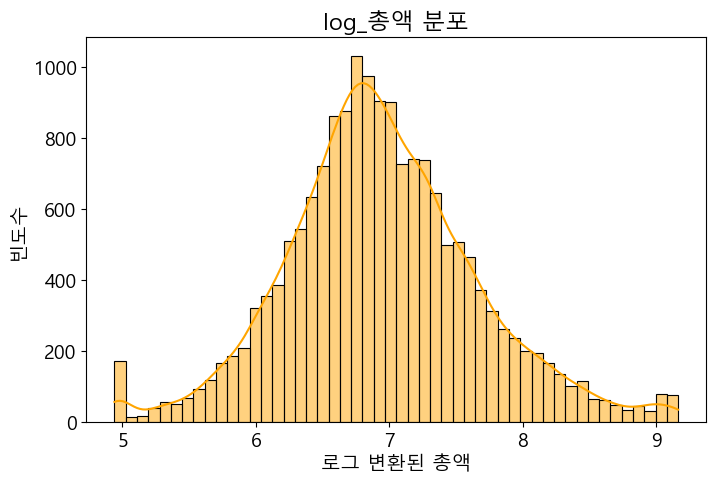

In [77]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['log_총액'], bins=50, kde=True, color='orange')
plt.title("log_총액 분포")
plt.xlabel("로그 변환된 총액")
plt.ylabel("빈도수")
plt.show()

In [34]:
# 연령대별 평균 log_총액 구하기
avg_log_by_age = df_all.groupby('연령대_단순')['log_총액'].mean().round(3)
print(avg_log_by_age)

연령대_단순
10대       6.798
20대       6.870
30~50대    7.003
60대 이상    6.829
Name: log_총액, dtype: float64


In [37]:
df_all['예상_총액'] = np.exp(df_all['log_총액']) - 1

In [38]:
avg_total_by_age = df_all.groupby('연령대_단순')['예상_총액'].mean().round(1)
print(avg_total_by_age)

연령대_단순
10대       1159.0
20대       1267.6
30~50대    1444.3
60대 이상    1251.9
Name: 예상_총액, dtype: float64


### 연령대별 자녀 동반 여부에 따른 소비 총액 차이

#### 연령대_단순 기준 
- 10대, 20대, 30~50대, 60대 이상

In [ ]:
# 동행자_세분화 컬럼 중에서 '자녀'와 함께온 관광객은 자녀O, 아닌 그룹은 자녀X 그룹으로 나눔
df_all['자녀동반'] = df_all['동행자_세분화'].apply(lambda x: '자녀O' if x == '자녀' else '자녀X')

In [61]:
df_all['연령대_단순'].value_counts()

연령대_단순
30~50대    9596
20대       6117
60대 이상     974
10대        436
Name: count, dtype: int64

In [62]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_단순').size()

연령대_단순
10대         1
20대        15
30~50대    698
60대 이상    114
dtype: int64

In [76]:
print(df_all['자녀동반'].unique())

['자녀X' '자녀O']


In [64]:
# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_단순'] != '10대']

In [65]:
# 연령대별 × 자녀 동반 여부별 평균 소비액 확인
## 예상 총액 기준으로 평균 비교
pivot = df_filtered.pivot_table(
    index='연령대_단순',
    columns='자녀동반',
    values='예상_총액',
    aggfunc='mean'
).round(1)

print(pivot)

자녀동반       자녀O     자녀X
연령대_단순                
20대     1360.4  1267.4
30~50대  1298.2  1455.7
60대 이상  1172.4  1262.5


In [71]:
# 자녀 동반 비율
# 전체 인원 수
total = df_filtered.groupby('연령대_단순').size()

# 자녀동반 인원 수
with_child = df_filtered[df_filtered['자녀동반'] == '자녀O'].groupby('연령대_단순').size()

# 비율 계산
pivot['자녀동반비율'] = (with_child / total * 100).round(1).astype(str) + '%'

print(with_child)
pivot['자녀동반비율']

연령대_단순
20대        15
30~50대    698
60대 이상    114
dtype: int64


연령대_단순
20대        0.2%
30~50대     7.3%
60대 이상    11.7%
Name: 자녀동반비율, dtype: object

| 연령대     | 자녀O 평균 소비액 | 자녀X 평균 소비액 | 차이 (자녀X - 자녀O)            |
| ------- | ---------- | ---------- | ------------------------- |
| 20대     | \$1,360.4  | \$1,267.4  | **-93.0** (자녀 동반 시 소비 ↑)  |
| 30\~50대 | \$1,298.2  | \$1,455.7  | **+157.5** (자녀 동반 시 소비 ↓) |
| 60대 이상  | \$1,172.4  | \$1,262.5  | **+90.1** (자녀 동반 시 소비 ↓)  |


- 20대만 자녀 동반 시 소비가 증가 (다만, 표본수가 다른 그룹보다 적기에 신뢰도 낮음)
- 30~50대는 자녀 동반 시 평균 소비 감소 (30~50대 전체 표본수에 비해 자녀와 함계한 30~50대의 표본차가 큼)
- 자녀 미동반 시 평균 소비가 약 $157 더 높음
- 자녀 동반 시 비용 부담을 줄이거나, 여행 스타일 자체가 달라질 가능성 존재
- 체험 위주 -> 실내/단기 체류
- 60대도 비슷한 경향
- 자녀 미동반 시 소비가 더 높음
- 다만 전반적으로 평균 소비 자체가 낮음 (60대 특징)

- 30~50대: 자녀 없이 여행하는 중장년층이 가장 높은 소비력 보유층으로 타겟팅 가치 큼
- 60대 이상: 자녀와 함께 여행하더라도 소비는 제한적 → 저가형, 휴식형 콘텐츠 전략 적합

#### 연령대_세분화 기준

In [73]:
df_all.query("자녀동반 == '자녀O'").groupby('연령대_세분화').size()

연령대_세분화
10대         1
20대        15
30대       113
40대       206
50대       379
60대 이상    114
dtype: int64

In [74]:
# 10대 제외 필터링
df_filtered = df_all[df_all['연령대_세분화'] != '10대']

In [75]:
# 연령대별 × 자녀 동반 여부별 평균 소비액 확인
## 예상 총액 기준으로 평균 비교
pivot = df_filtered.pivot_table(
    index='연령대_세분화',
    columns='자녀동반',
    values='예상_총액',
    aggfunc='mean'
).round(1)

print(pivot)

자녀동반        자녀O     자녀X
연령대_세분화                
20대      1360.4  1267.4
30대      1329.7  1468.1
40대      1424.3  1480.2
50대      1220.3  1409.9
60대 이상   1172.4  1262.5


### 왜 자녀를 동반하면 소비가 줄어들까?

1. 1인당 지출이 분산됨
- 숙소·음식·이동 등에서 전체 비용은 증가하나, 개별 체험/사치 지출은 감소

2. 자녀 중심 일정으로 전환됨
- 웰니스 콘텐츠(명상, 뷰티, 스파 등)는 어른 중심 활동
- 자녀가 있으면 소극적 선택, 체험 종류 제한됨

3. 예산 조정 심리
- 가족 단위 여행은 전체 예산이 커지므로, 개별 항목에서 지출 절제

4. 왜 30~50대 자녀 미동반자는 핵심 소비자인가?
- 경제활동 주력층 + 체력과 여가 모두 확보된 세대
- 자녀 없이 여행할 경우: 자기만족 중심 소비 가능
- 웰니스 콘텐츠(명상, 스파, 치유 등)에 높은 관심과 지출 여력

5. 결론
- 웰니스 관광의 핵심 소비자는 ‘자녀 없이 여행하는 30~50대’다.

- 관광객 / 웰니스 관광객 구분해서 더 분석해보기